DNN이란, 우리 뇌와 같이 여러 개의 뉴런들이 (축색돌기, 수상돌기, 시냅스)로 연결되어 있는 것을 컴퓨터 알고리즘으로 구현한 것이다.
지금까지 배운 것과 다른 점은 은닉층의 층수가 많아졌다는 것에 있다.


In [2]:
# Package imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
import sklearn.datasets
import sklearn.linear_model
# Our own private imports
import imp
import joy
imp.reload(joy)

%matplotlib inline
np.random.seed(1)   # a good practice for reproducibility and debugging

# The following code is used for hiding the warnings and 
# make this notebook clearer.
#import warnings
#warnings.filterwarnings('ignore')

아래는 DNN을 위한 다양한 활성화 함수들을 정리해봤다.
은닉층별로 다른 활성화 함수를 사용할 수 있으므로, 다양하게 알아두는 것이 좋을 것이다.

In [3]:
def tanh(x):
    return (1.0 - np.exp(-2 * x))/(
            1.0 + np.exp(-2 * x))
def tanh_d(x):
    return (1 + tanh(x)) * (1 - tanh(x))

def sigmoid(x): 
    #x = np.clip(x, -500, 500)  
    return 1 / (1 + np.exp((-x)))

def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

def relu(x):
    return np.maximum(x, 0)

def relu_d(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [4]:
import sys
class DeepNeuralNet(object):
    """ implements a deep neural net. 
        Users may specify any number of layers.
        net_arch -- consists of a number of neurons in each layer 
    """
    def __init__(self, net_arch, activate = None, eta = 1.0, epochs = 100, random_seed = 1):
        self.eta = eta
        self.epochs = epochs
        self.net_arch = net_arch
        self.layers = len(net_arch)
        self.W = []
        self.random_seed = random_seed
        
        self.g       = [lambda x: sigmoid(x)   for _ in range(self.layers)]
        self.g_prime = [lambda x: sigmoid_d(x) for _ in range(self.layers)]
        
        if activate is not None:
            for i, (g, g_prime) in enumerate(zip(activate[::2], activate[1::2])):
                self.g[i+1] = g
                self.g_prime[i+1] = g_prime
                
        for i in range(len(self.g)):
            print(type(self.g[i]), id(self.g[i]))
        
        #print('X.shape={}, y.shape{}'.format(X.shape, y.shape))
        # Random initialization with range of weight values (-1,1)
        np.random.seed(self.random_seed)
        
        # A place holder [None] is used to indicated "unused place".
        self.W = [[None]]    ## the first W0 is not used.
        for layer in range(self.layers - 1):
            w = 2 * np.random.rand(self.net_arch[layer+1], 
                                   self.net_arch[layer]) - 1
            print('layer:', layer, 'shape:', w.shape)
            self.W.append(w)  
        print('Weight:', self.W)
    
    #순방향: 각 층별로 가중치와 출력값을 곱하고 활성화 함수에 넣은 값을 리스트에 저장한다.       
    def forpass(self, A0):     
        Z = [[None]]   # Z0 is not used.
        A = []       # A0 = X0 is used. 
        A.append(A0)
        for i in range(1, len(self.W)):
            z = np.dot(self.W[i], A[i-1])
            Z.append(z)
            a = self.g[i](z)
            A.append(a)
        return Z, A
    
    #역방향: 가중치를 조정하기 위해서 사용된다.
    def backprop(self, Z, A, Y):
        # initialize empty lists to save E and dZ
        # A place holder None is used to indicated "unused place".
        E  = [None for x in range(self.layers)]
        dZ = [None for x in range(self.layers)]
        
        # Get error at the output layer or the last layer
        ll = self.layers - 1
        error = Y - A[ll]
        E[ll] = error   
        dZ[ll] = error * self.g_prime[ll](Z[ll]) 
        
        # Begin from the back, from the next to last layer
        for i in range(self.layers-2, 0, -1):
            E[i]  = np.dot(self.W[i+1].T, E[i+1])
            dZ[i] = E[i] * self.g_prime[i](Z[i])
       
        # Adjust the weights, using the backpropagation rules
        m = Y.shape[0] # number of samples
        for i in range(ll, 0, -1):
            self.W[i] += self.eta * np.dot(dZ[i], A[i-1].T) / m
        return error
     #학습을 위해 사용 된다.    
    def fit(self, X, y):
        print('fit')
        self.cost_ = []        
        for epoch in range(self.epochs):          
            Z, A = self.forpass(X)        
            cost = self.backprop(Z, A, y)   
            self.cost_.append(
                 np.sqrt(np.sum(cost * cost)))    
        return self

    def predict(self, X):
        print('predict')
        A0 = np.array(X, ndmin=2).T         # A0: inputs
        Z, A = self.forpass(A0)     # forpass
        return A[-1]                                       
   
    def evaluate(self, Xtest, ytest):       # fully vectorized calculation
        print('evaluate')
        m_samples = len(ytest)
        scores = 0        
        A3 = self.predict(Xtest)
        yhat = np.argmax(A3, axis = 0)
        scores += np.sum(yhat == ytest)
        return scores/m_samples * 100

[[0 0 1 1]
 [0 1 0 1]] 
 [0 1 1 0]
<class 'function'> 1759508895640
<class 'function'> 1759508895208
<class 'function'> 1759508895064
<class 'function'> 1759508894920
layer: 0 shape: (4, 2)
layer: 1 shape: (2, 4)
layer: 2 shape: (1, 2)
Weight: [[None], array([[-0.16595599,  0.44064899],
       [-0.99977125, -0.39533485],
       [-0.70648822, -0.81532281],
       [-0.62747958, -0.30887855]]), array([[-0.20646505,  0.07763347, -0.16161097,  0.370439  ],
       [-0.5910955 ,  0.75623487, -0.94522481,  0.34093502]]), array([[-0.1653904 ,  0.11737966]])]
fit
predict
[0 0] [0.011]
[0 1] [0.991]
[1 0] [0.991]
[1 1] [0.009]
predict


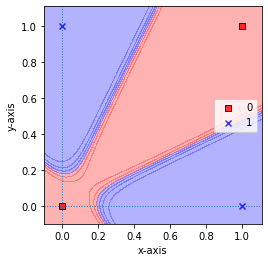

In [5]:
# XOR 문제를 해결해보자.
import joy
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

# Set the input data and labels for XOR
X = np.array([ [0, 0, 1, 1], [0, 1, 0, 1] ])
y = np.array([0, 1, 1, 0])
print(X, "\n", y)

# Initialize the deep neural net with
dnn = DeepNeuralNet([2, 4, 2, 1], eta = 0.9, epochs = 10000)  

# training the deep neural net objcet with X, y
dnn.fit(X, y)             
    
Ao = dnn.predict(X.T)
for x, yhat in zip(X.T, Ao.T):
    print(x, np.round(yhat, 3))

joy.plot_decision_regions(X.T, y, dnn)   
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='best')
plt.show()

<class 'function'> 1759544935192
<class 'function'> 1759544936200
<class 'function'> 1759544934904
<class 'function'> 1759544936056
layer: 0 shape: (4, 2)
layer: 1 shape: (3, 4)
layer: 2 shape: (1, 3)
Weight: [[None], array([[-0.16595599,  0.44064899],
       [-0.99977125, -0.39533485],
       [-0.70648822, -0.81532281],
       [-0.62747958, -0.30887855]]), array([[-0.20646505,  0.07763347, -0.16161097,  0.370439  ],
       [-0.5910955 ,  0.75623487, -0.94522481,  0.34093502],
       [-0.1653904 ,  0.11737966, -0.71922612, -0.60379702]]), array([[ 0.60148914,  0.93652315, -0.37315164]])]
fit
predict


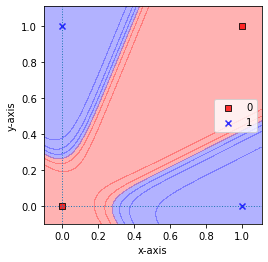

In [6]:
import joy
X = np.array([ [0, 0, 1, 1], [0, 1, 0, 1] ])
y = np.array([0, 1, 1, 0])
dnn = DeepNeuralNet([2, 4, 3, 1], eta = 0.5, epochs = 5000).fit(X, y)   

joy.plot_decision_regions(X.T, y, dnn)   
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='best')
plt.show()

오차의 시각화

<class 'function'> 1759549407096
<class 'function'> 1759549405512
<class 'function'> 1759549403928
layer: 0 shape: (4, 2)
layer: 1 shape: (1, 4)
Weight: [[None], array([[-0.16595599,  0.44064899],
       [-0.99977125, -0.39533485],
       [-0.70648822, -0.81532281],
       [-0.62747958, -0.30887855]]), array([[-0.20646505,  0.07763347, -0.16161097,  0.370439  ]])]
fit
<class 'function'> 1759567988776
<class 'function'> 1759508919496
<class 'function'> 1759508919496
<class 'function'> 1759508909800
layer: 0 shape: (3, 2)
layer: 1 shape: (2, 3)
layer: 2 shape: (1, 2)
Weight: [[None], array([[-0.16595599,  0.44064899],
       [-0.99977125, -0.39533485],
       [-0.70648822, -0.81532281]]), array([[-0.62747958, -0.30887855, -0.20646505],
       [ 0.07763347, -0.16161097,  0.370439  ]]), array([[-0.5910955 ,  0.75623487]])]
fit
<class 'function'> 1759567987768
<class 'function'> 1759508919496
<class 'function'> 1759508919496
<class 'function'> 1759508909800
layer: 0 shape: (2, 2)
layer: 1 s

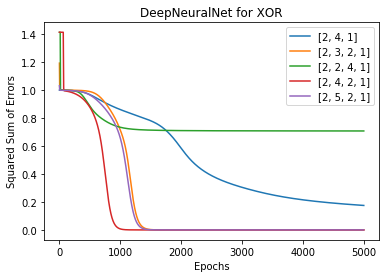

In [19]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

X = np.array([ [0, 0, 1, 1], [0, 1, 0, 1] ])
y = np.array([0, 1, 1, 0])
g = [sigmoid, sigmoid_d, sigmoid, sigmoid_d, relu, relu_d]
dnn1 = DeepNeuralNet([2,4,1], eta = 0.5, epochs = 5000).fit(X, y) 
dnn2 = DeepNeuralNet([2,3,2,1], activate=g, eta = 0.5, epochs = 5000).fit(X, y) 
dnn3 = DeepNeuralNet([2,2,4,1], activate=g, eta = 0.5, epochs = 5000).fit(X, y) 
dnn4 = DeepNeuralNet([2,4,2,1], activate=g, eta = 0.5, epochs = 5000).fit(X, y) 
dnn5 = DeepNeuralNet([2,5,2,1], activate=g, eta = 0.5, epochs = 5000).fit(X, y) 

plt.plot(range(len(dnn1.cost_)), dnn1.cost_, label='{}'.format(dnn1.net_arch))
plt.plot(range(len(dnn2.cost_)), dnn2.cost_, label='{}'.format(dnn2.net_arch))
plt.plot(range(len(dnn3.cost_)), dnn3.cost_, label='{}'.format(dnn3.net_arch))
plt.plot(range(len(dnn4.cost_)), dnn4.cost_, label='{}'.format(dnn4.net_arch))
plt.plot(range(len(dnn5.cost_)), dnn5.cost_, label='{}'.format(dnn5.net_arch))
plt.title('DeepNeuralNet for XOR')
plt.xlabel('Epochs')
plt.ylabel('Squared Sum of Errors')
plt.legend(loc='best')
plt.show()

각 층별로 다른 활성화 함수를 사용해보자!

[[0 0 1 1]
 [0 1 0 1]] 
 [0 1 1 0]
<class 'function'> 1759550414424
<class 'function'> 1759508920216
<class 'function'> 1759508919496
<class 'function'> 1759508919496
layer: 0 shape: (4, 2)
layer: 1 shape: (2, 4)
layer: 2 shape: (1, 2)
Weight: [[None], array([[-0.16595599,  0.44064899],
       [-0.99977125, -0.39533485],
       [-0.70648822, -0.81532281],
       [-0.62747958, -0.30887855]]), array([[-0.20646505,  0.07763347, -0.16161097,  0.370439  ],
       [-0.5910955 ,  0.75623487, -0.94522481,  0.34093502]]), array([[-0.1653904 ,  0.11737966]])]
fit
<class 'function'> 1759550168088
<class 'function'> 1759508920216
<class 'function'> 1759508909800
<class 'function'> 1759508920216
layer: 0 shape: (4, 2)
layer: 1 shape: (2, 4)
layer: 2 shape: (1, 2)
Weight: [[None], array([[-0.16595599,  0.44064899],
       [-0.99977125, -0.39533485],
       [-0.70648822, -0.81532281],
       [-0.62747958, -0.30887855]]), array([[-0.20646505,  0.07763347, -0.16161097,  0.370439  ],
       [-0.5910955 

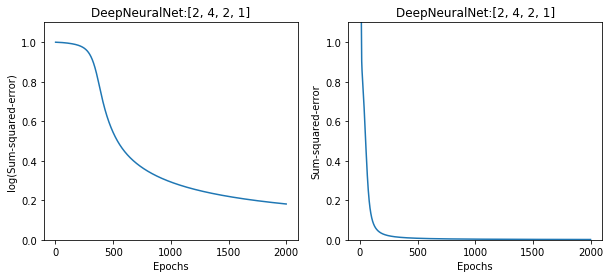

In [16]:
X = np.array([ [0, 0, 1, 1], [0, 1, 0, 1] ])
y = np.array([0, 1, 1, 0])
print(X, "\n", y)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

g = [tanh, tanh_d, sigmoid, sigmoid_d, sigmoid, sigmoid_d]
dnn1 = DeepNeuralNet([2, 4, 2, 1], activate = g, eta = 0.5, epochs = 2000).fit(X,y)
ax[0].plot(range(1, len(dnn1.cost_) + 1), dnn1.cost_)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_ylim([0.0, 1.1])
ax[0].set_title('DeepNeuralNet:{}'.format(dnn1.net_arch))

g = [tanh, tanh_d, relu, relu_d, tanh, tanh_d]
dnn2 = DeepNeuralNet([2, 4, 2, 1], activate = g, eta=0.5, epochs=2000).fit(X, y)
ax[1].plot(range(1, len(dnn2.cost_) + 1), dnn2.cost_)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_ylim([0.0, 1.1])
ax[1].set_title('DeepNeuralNet:{}'.format(dnn2.net_arch))
plt.show()

[[0 0 1 1]
 [0 1 0 1]] 
 [0 1 1 0]
<class 'function'> 1759546608664
<class 'function'> 1759508920216
<class 'function'> 1759508919496
<class 'function'> 1759508919496
layer: 0 shape: (18, 2)
layer: 1 shape: (4, 18)
layer: 2 shape: (1, 4)
Weight: [[None], array([[-0.16595599,  0.44064899],
       [-0.99977125, -0.39533485],
       [-0.70648822, -0.81532281],
       [-0.62747958, -0.30887855],
       [-0.20646505,  0.07763347],
       [-0.16161097,  0.370439  ],
       [-0.5910955 ,  0.75623487],
       [-0.94522481,  0.34093502],
       [-0.1653904 ,  0.11737966],
       [-0.71922612, -0.60379702],
       [ 0.60148914,  0.93652315],
       [-0.37315164,  0.38464523],
       [ 0.7527783 ,  0.78921333],
       [-0.82991158, -0.92189043],
       [-0.66033916,  0.75628501],
       [-0.80330633, -0.15778475],
       [ 0.91577906,  0.06633057],
       [ 0.38375423, -0.36896874]]), array([[ 0.37300186,  0.66925134, -0.96342345,  0.50028863,  0.97772218,
         0.49633131, -0.43911202,  0.578

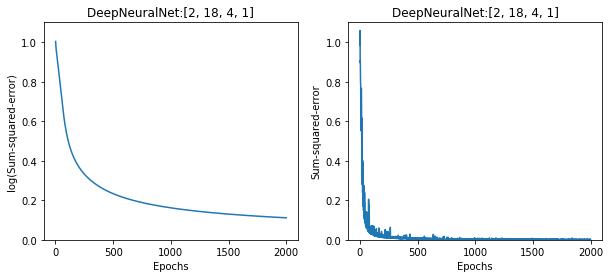

In [11]:

# Set the input data and labels for XOR
X = np.array([ [0, 0, 1, 1], [0, 1, 0, 1] ])
y = np.array([0, 1, 1, 0])
print(X, "\n", y)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

g = [tanh, tanh_d, sigmoid, sigmoid_d, sigmoid, sigmoid_d]
dnn1 = DeepNeuralNet([2, 18, 4, 1], activate = g, eta = 0.5, epochs = 2000).fit(X,y)
ax[0].plot(range(1, len(dnn1.cost_) + 1), dnn1.cost_)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_ylim([0.0, 1.1])
ax[0].set_title('DeepNeuralNet:{}'.format(dnn1.net_arch))

g = [tanh, tanh_d, relu, relu_d, tanh, tanh_d]
dnn2 = DeepNeuralNet([2, 18, 4, 1], activate = g, eta=0.5, epochs=2000).fit(X, y)
ax[1].plot(range(1, len(dnn2.cost_) + 1), dnn2.cost_)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Sum-squared-error')
ax[1].set_ylim([0.0, 1.1])
ax[1].set_title('DeepNeuralNet:{}'.format(dnn2.net_arch))
plt.show()